<a href="https://colab.research.google.com/github/yash26061981/Airline_Analysis_NLP_Sentiment_Recommender/blob/main/Airline_Analysis_Demo_Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Transformer

# Mounting Drive to access files and save models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing necessary libraries

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split

# Reading filtered airline data.

In [ ]:
df_dtype = pd.read_csv('./drive/MyDrive/Colab_Notebooks/PreprocessedDataLightTypes.csv')
dict_dtype = df_dtype[['index','dtypes']].set_index('index').to_dict()['dtypes']
dict_dtype['recommended'] = 'bool'

airline_data_filtered_file = './drive/MyDrive/Colab_Notebooks/PreprocessedDataLight.csv'
airline_data = pd.read_csv(airline_data_filtered_file, dtype=dict_dtype, keep_default_na=False, na_values=['_'])
airline_data.drop(columns=['Unnamed: 0'],inplace=True)
#airline_data = pd.read_csv(airline_data_filtered_file)
airline_data.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,review_date_month,review_date_year,date_flown_day,date_flown_month,date_flown_year,review_date_date_flown_distance_days,review_characters,pos_neu_neg_review_score,has_layover,recommended
0,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,5.0,2019.0,1.0,5.0,2019.0,7.0,1094,pos,True,True
1,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,5.0,2019.0,1.0,5.0,2019.0,6.0,425,neg,False,False
2,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,5.0,2019.0,1.0,5.0,2019.0,6.0,1597,neg,True,False
3,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,5.0,2019.0,24.0,4.0,2019.0,12.0,875,pos,False,True
4,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,5.0,2019.0,1.0,5.0,2019.0,5.0,366,neg,True,False


In [ ]:
airline_data.groupby(['pos_neu_neg_review_score']).size().sort_values(ascending=False).reset_index(name='frequency')

,pos_neu_neg_review_score,frequency
0,neg,10794
1,pos,10014
2,neu,2014


# Our first attempt is to build a model which can detect the sentiments in the review text. As sentiments are derived feature from review score, we categorise the sentiments in 3 buckets.

In [ ]:
train_df = airline_data[['review_text', 'pos_neu_neg_review_score']]
train_df.rename(columns={'review_text':'reviews'}, inplace=True)
train_df.rename(columns={'pos_neu_neg_review_score':'sentiment'}, inplace=True)
train_df.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,reviews,sentiment
0,First time Iâ€™d flown TK. I found them very ...,pos
1,"We make our check in in the airport, they Tak...",neg
2,I flew with this company several times in the...,neg
3,Turkish Airlines has consistently maintained ...,pos
4,Never book Turkish airlines if you are travel...,neg


# Filterd reviews has some non-alphanumeric characters. We have to remove those characters and to make tf.dataset, all reviews has to be encoded as utf-8

In [ ]:
utf8_data = train_df.copy()
utf8_data.shape

(22822, 2)

In [ ]:
utf8_data.head()

,reviews,sentiment
0,First time Iâ€™d flown TK. I found them very ...,pos
1,"We make our check in in the airport, they Tak...",neg
2,I flew with this company several times in the...,neg
3,Turkish Airlines has consistently maintained ...,pos
4,Never book Turkish airlines if you are travel...,neg


In [ ]:
utf8_data['reviews'] = utf8_data.reviews.str.replace('[^a-zA-Z ]', ' ')
utf8_data.head()

<ipython-input-9-18174823ca8d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  utf8_data['reviews'] = utf8_data.reviews.str.replace('[^a-zA-Z ]', ' ')


,reviews,sentiment
0,First time I d flown TK I found them very ...,pos
1,We make our check in in the airport they Tak...,neg
2,I flew with this company several times in the...,neg
3,Turkish Airlines has consistently maintained ...,pos
4,Never book Turkish airlines if you are travel...,neg


In [ ]:
utf8_data.dtypes

reviews      object
sentiment    object
dtype: object

In [ ]:
#utf8_data = utf8_data.sample(frac=0.4)

# Converting sentiments to one-hot encoded values.
# Positive -> 2, Neutral -> 1, Negative -> 0

In [ ]:
data = utf8_data.copy()
# Converting type of columns to category
data['sentiment']=data['sentiment'].astype('category')
 
 
#Assigning numerical values and storing it in another columns
data['sentiment_new']=data['sentiment'].cat.codes
 
#Create an instance of One-hot-encoder
enc=OneHotEncoder()
 
#Passing encoded columns
enc_data=pd.DataFrame(enc.fit_transform(data[['sentiment_new']]).toarray())
 
#Merge with main
data=data.join(enc_data)
data.head()

,reviews,sentiment,sentiment_new,0,1,2
15417,Food was very tasty But the flight was two h...,neu,1,NaN,NaN,NaN
22188,Norwegian has modern planes good service and...,pos,2,NaN,NaN,NaN
888,London to Doha A am flight on time from...,pos,2,0.0,0.0,1.0
9958,British Airways has been the airline our orga...,neg,0,NaN,NaN,NaN
17938,Worst cabin crew ever It left Delhi on time ...,neu,1,NaN,NaN,NaN


In [ ]:
data.drop(columns=['sentiment',0,1,2],inplace=True)
data.head()

,reviews,sentiment_new
15417,Food was very tasty But the flight was two h...,1
22188,Norwegian has modern planes good service and...,2
888,London to Doha A am flight on time from...,2
9958,British Airways has been the airline our orga...,0
17938,Worst cabin crew ever It left Delhi on time ...,1


In [ ]:
data.rename(columns = {'sentiment_new':'sentiment'}, inplace = True)
data.head()

,reviews,sentiment
15417,Food was very tasty But the flight was two h...,1
22188,Norwegian has modern planes good service and...,2
888,London to Doha A am flight on time from...,2
9958,British Airways has been the airline our orga...,0
17938,Worst cabin crew ever It left Delhi on time ...,1


In [ ]:
#data["sentiment"] = data["sentiment"].apply(pd.to_numeric, downcast='float', errors='coerce')
#data.head()

# Spiltting the dataset in train, test, validation.

In [ ]:
#train, validate, test = np.split(data.sample(frac=1, random_state=42), [int(.6*len(data)), int(.8*len(data))])

train, test = train_test_split(data, test_size=0.3)

In [ ]:
#train['reviews'] = train['reviews'].str.decode("utf-8")
train.head()

,reviews,sentiment
14722,So lots of people blocking aisles at all part...,1
1042,Have flown numerous times with numerous airli...,2
7982,This was by far the worst experience that I h...,0
5813,The flight was nice with very good in flight...,2
20807,We were impressed with all aspects of the in ...,2


In [ ]:
train.shape

(6390, 2)

In [ ]:
train.dtypes

reviews      object
sentiment      int8
dtype: object

In [ ]:
test.head()

,reviews,sentiment
1053,Overall a reasonable experience I was not so...,2
7415,By far worst airline I have ever flown with ...,0
19998,Bait and switch at its finest I used their s...,0
9302,Horrible baggage service and terrible follow ...,0
9916,They were basically on both flights rushing...,0


In [ ]:
test.shape

(2739, 2)

In [ ]:
test.dtypes

reviews      object
sentiment      int8
dtype: object

# Create tf dataset for processing

In [ ]:
var_sentiment_train = train.pop('sentiment')

tf_train_dataset = tf.data.Dataset.from_tensor_slices((train.values, var_sentiment_train.values))

for features, targets in tf_train_dataset.take(5):
    print(f'Text: {features.numpy()} \n')
    print(f'Label: {targets.numpy()} \n')
    print('Features: {}, Target: {}'.format(features, targets))

Text: [b' So lots of people blocking aisles at all parts of the plane  Non working onboard entertainment  Air France needs to come into the   st century with its onboard entertainment  Their system  which wasn t working looks like it was designed by a high school student who failed at programming in his computer course  Really bad  Language skills  The Purser on our flight had minimal English language skills  She stumbled so much that we stopped listening to her  Seats  We were in two seats  which were OK  but it was hard to get in and out  because the seats are so close together  Food  Surprisingly mediocre '] 

Label: 1 

Features: [b' So lots of people blocking aisles at all parts of the plane  Non working onboard entertainment  Air France needs to come into the   st century with its onboard entertainment  Their system  which wasn t working looks like it was designed by a high school student who failed at programming in his computer course  Really bad  Language skills  The Purser on

In [ ]:
var_sentiment_test = test.pop('sentiment')

tf_test_dataset = tf.data.Dataset.from_tensor_slices((test.values, var_sentiment_test.values))

for features, targets in tf_test_dataset.take(5):
    print(f'Text: {features.numpy()} \n')
    print(f'Label: {targets.numpy()} \n')
    print('Features: {}, Target: {}'.format(features, targets))

Text: [b' Overall a reasonable experience  I was not so impressed with the A    and I found it hard to hear the IFE  The seat was not that spacious  Food onboard was fantastic  a good portion for dinner which included salad  roll with cheese  sweet Thai chilli chicken with jasmine rice and steamed vegetables and a summer fruit cheese cake  There was also a light sandwich and muffin with coffee before we started to land  The IFE was quite good  but not as much choice as some airlines  The on board staff were pleasant '] 

Label: 2 

Features: [b' Overall a reasonable experience  I was not so impressed with the A    and I found it hard to hear the IFE  The seat was not that spacious  Food onboard was fantastic  a good portion for dinner which included salad  roll with cheese  sweet Thai chilli chicken with jasmine rice and steamed vegetables and a summer fruit cheese cake  There was also a light sandwich and muffin with coffee before we started to land  The IFE was quite good  but not as

# Shuffling train and test dataset.

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = tf_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf_test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Learning the Vocabulary


Next step is to transforms a batch of strings (one example = one string) into either a list of token indices (one example = 1D tensor of integer token indices) or a dense representation (one example = 1D tensor of float values representing data about the example's tokens). 

To do so the vocabulary for the layer must be either supplied on construction or learned via adapt(). When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a vocabulary from them. This vocabulary can have unlimited size or be capped, depending on the configuration options for this layer; if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary. 

The processing of each example contains the following steps:

 * Standardize each example (usually lowercasing + punctuation stripping)
 * Split each example into substrings (usually words)
 * Recombine substrings into tokens (usually ngrams)
 * Index tokens (associate a unique int value with each token)
 * Transform each example using this index, either into a vector of ints or a dense float vector.


In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE) #, output_sequence_length=100)


encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'and', 'was', 'a', 'i', 'in', 'flight',
       'of', 'on', 'for', 'with', 'we', 'were', 'it', 'my', 'is', 'that'],
      dtype='<U14')

In [ ]:
len(vocab)

1000

In [ ]:
for example, label in train_dataset.take(1):
    print(f"Texts : {example.numpy()[:3]} \n")
    print(f"Labels: {label.numpy()[:3]} \n")
    print("----")
encoded_example = encoder(example)[:3].numpy()
encoded_example

Texts : [[b' I got a very warm greeting from the flight attendant when entering the aircraft and selection of welcome drink  I choose champagne  The Sky Chef came out to offer the lunch menu and drink  I choose Cod fish and Italian dry white wine  which was very good  I have to say that the meal was beyond my expectation  Flight attendant was very attentive  often came to fill up my wine and very nice personality  asking me if I did enjoy the flight or not  When arrived to Bahrain  I used the Falcon Gold lounge waiting for my next flight to Frankfurt  The lounge is large  choices of meals and drinks  Meal in the lounge taste quite good  I took beef stew and deep fried chicken  Drinks  a lot of choice from juice to beer  wine and champagne too  Again flight from Bahrain to Frankfurt  They use smaller aircraft  A     but seat is comfortable and large space  Since it was a late night flight  So  I was serve only light meal and choose Garden Salad and drink champagne  I think that it was n

array([[  7, 109,   6, ...,   0,   0,   0],
       [ 16,   5, 284, ...,   0,   0,   0],
       [  1,   7, 550, ...,   0,   0,   0]])

# Our dataset containing processed input sequences tokens and are ready for the training.

## Our first model is Sequential Seq2Seq model with LSTM layers, trained on the sentiments.

In [ ]:
model = tf.keras.Sequential([tf.keras.Input(shape=(1,), dtype=tf.string),
                             encoder, tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1)])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

This model contains 0.1 Million traianable parameters.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

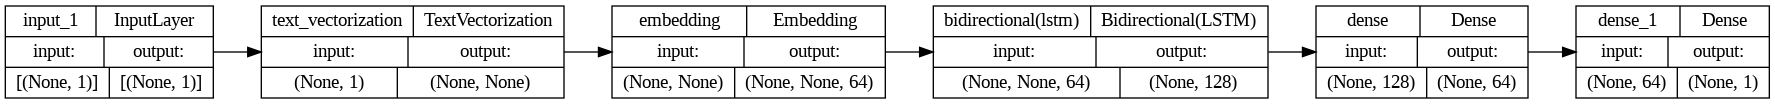

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset, 
                    validation_steps=25)

Epoch 1/5
100/100 [==============================] - 155s 1s/step - loss: 0.5336 - accuracy: 0.3671 - val_loss: 0.1764 - val_accuracy: 0.0900
Epoch 2/5
100/100 [==============================] - 121s 1s/step - loss: 0.0320 - accuracy: 0.0883 - val_loss: -0.5979 - val_accuracy: 0.0862
Epoch 3/5
100/100 [==============================] - 117s 1s/step - loss: -2.8219 - accuracy: 0.2235 - val_loss: -5.9772 - val_accuracy: 0.3713
Epoch 4/5
100/100 [==============================] - 120s 1s/step - loss: -8.3555 - accuracy: 0.4039 - val_loss: -10.2151 - val_accuracy: 0.3800
Epoch 5/5
100/100 [==============================] - 118s 1s/step - loss: -14.5447 - accuracy: 0.4003 - val_loss: -17.3529 - val_accuracy: 0.4606


Above values shows the loss in negative. Though that makes sense as it may happen when data values are more and there's nothing wrong with having a negative-loss function as such. It's just a function that has to be minimized, and model weights are updated according to that.

# Evaluating and saving the trained model

In [ ]:
# evaluate the model
scores = model.evaluate(test_dataset, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 45.56%


In [ ]:
model.save('./drive/MyDrive/Colab_Notebooks/lstm_sentiment_model')

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])



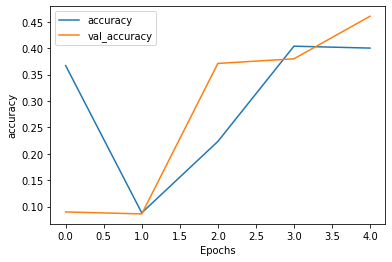

In [ ]:
plot_graphs(history, "accuracy")

##Predictions using above trained model

In [ ]:
lstm_sentiment_classifier = tf.keras.models.load_model('./drive/MyDrive/Colab_Notebooks/lstm_sentiment_model')

sample_text = [('Very positive experience with Indigo. Easy baggage-drop at Lucknow airport, new aircraft,' 
                'well trained crew. Very good airline, warmly recommended.'),
               ('Indigo charges extra for its seat selection. And now I dont understand why the flight attendant asked '
               'me to change my seat which is lower than what i paid. I left with no choice cause its for an child ' 
                'with 2.5yrs. Its crazy Indigo has to fine tune its reservation system. The family who booked'
                'the seats got the seats in 3 different places.'),
               ('Recently as an international travel booked return flight, continue to experience problems of scheduling '
               'and rescheduling by the airline, with no head or tail. Difficult to contact either online or web chat '
               'or on the phone to speak to customer service from abroad from abroad. The whole service is below par.'),
               ('No doubt Indigo is best LCC in India, smooth check in, on time sequential boarding and departure. Okay seats, '
               'clean hygiene cabin, courteous cabin crew. Another good experience and reason to fly again with them next time.'),
               ('I used the Indigo flight from Jaipur to Bengaluru. It was ok.')]

for count, st in enumerate(sample_text):  
  predictions = lstm_sentiment_classifier.predict(np.array([st]), verbose=0)
  p = np.squeeze(predictions)
  p = int(p)
  if p < 0:
    print("Setiment in {} Statement is = Negative Review".format(count+1))
  elif p > 1:
    print("Setiment in {} Statement is = Positive Review".format(count+1))
  else:
    print("Setiment in {} Statement is = Neutral Review".format(count+1))


Setiment in 1 Statement is = Positive Review
Setiment in 2 Statement is = Negative Review
Setiment in 3 Statement is = Negative Review
Setiment in 4 Statement is = Positive Review
Setiment in 5 Statement is = Neutral Review


# Airline Recommender Model

## Since we saw that sentiment classifier model trained with 46% accuracy, we thought to build a recommender model. For this we will use the recommender column of dataset and build a Seq2Seq model

In [ ]:
train_df_1 = airline_data[['review_text', 'recommended']]
train_df_1.rename(columns={'review_text':'reviews'}, inplace=True)
data_1 = train_df_1.copy()
print(data_1.head(2))
data_1['reviews'] = data_1.reviews.str.replace('[^a-zA-Z ]', ' ')

# Converting type of columns to category
data_1['recommended']=data_1['recommended'].astype('category')
 
 
#Assigning numerical values and storing it in another columns
data_1['recommended_new']=data_1['recommended'].cat.codes
 
#Create an instance of One-hot-encoder
enc=OneHotEncoder()
 
#Passing encoded columns
enc_data=pd.DataFrame(enc.fit_transform(data_1[['recommended_new']]).toarray())
 
#Merge with main
data_1=data_1.join(enc_data)
data_1.head()
data_1.drop(columns=['recommended',0,1],inplace=True)
data_1.rename(columns = {'recommended_new':'recommended'}, inplace = True)
print(data_1.head())
train_1, test_1 = train_test_split(data_1, test_size=0.3)



                                             reviews  recommended
0   First time Iâ€™d flown TK. I found them very ...         True
1   We make our check in in the airport, they Tak...        False


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-38-00fb72b43b02>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data_1['reviews'] = data_1.reviews.str.replace('[^a-zA-Z ]', ' ')


                                             reviews  recommended
0   First time I   d flown TK  I found them very ...            1
1   We make our check in in the airport  they Tak...            0
2   I flew with this company several times in the...            0
3   Turkish Airlines has consistently maintained ...            1
4   Never book Turkish airlines if you are travel...            0


In [ ]:
airline_data.groupby(['recommended']).size().sort_values(ascending=False).reset_index(name='frequency')

,recommended,frequency
0,False,11759
1,True,11063


## Converting dataset to tensorflow dataset

In [ ]:
var_train_1 = train_1.pop('recommended')

tf_train_dataset_1 = tf.data.Dataset.from_tensor_slices((train_1.values, var_train_1.values))

for features, targets in tf_train_dataset_1.take(5):
    print(f'Text: {features.numpy()} \n')
    print(f'Label: {targets.numpy()} \n')
    print('Features: {}, Target: {}'.format(features, targets))

var_test_1 = test_1.pop('recommended')

tf_test_dataset_1 = tf.data.Dataset.from_tensor_slices((test_1.values, var_test_1.values))

for features, targets in tf_test_dataset_1.take(5):
    print(f'Text: {features.numpy()} \n')
    print(f'Label: {targets.numpy()} \n')
    print('Features: {}, Target: {}'.format(features, targets))


BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset_1 = tf_train_dataset_1.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset_1 = tf_test_dataset_1.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

VOCAB_SIZE = 1000
encoder_1 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE) #, output_sequence_length=100)

encoder_1.adapt(train_dataset_1.map(lambda text, label: text))

vocab_1 = np.array(encoder_1.get_vocabulary())

encoded_example = encoder_1(features)[:3].numpy()
encoded_example

Text: [b' I was expecting a favorable experience based on reviews I read online  But what I experienced was way beyond my expectation  It was the most pleasurable economy flight I have ever experienced  The the diversified  polite and helpful cabin crew were exceptional  Even their info video for airline safety prior to take off is innovative and refreshing  The food on board was average but still tolerable at the least  Freebies for the little ones including the food tray is exceptional  I would truly consider booking my future flights with this airline and highly recommend it to those who have not flown with them yet '] 

Label: 1 

Features: [b' I was expecting a favorable experience based on reviews I read online  But what I experienced was way beyond my expectation  It was the most pleasurable economy flight I have ever experienced  The the diversified  polite and helpful cabin crew were exceptional  Even their info video for airline safety prior to take off is innovative and refr

array([[ 10, 411, 506, 170, 160,   3, 462,  13,   1, 240,   1,  56,   8,
         42, 525,  13, 131, 771,   1,   1, 600, 647,  26, 101,   1,   1,
         10,  48,  38,   6,   1, 113,   1,   1,  38,  20,  19, 138,   1,
         23, 546,   2, 355, 329,  36,  12, 145, 325,   4, 237,  10, 142,
         79, 107,  35,  38, 790,  11, 659, 208,  78,   9,   1,  38,  44,
          8,  44,   7,  42, 239,  89]])

## Our Second model is Sequential Seq2Seq model with LSTM layers, trained on the recommendatations.

In [ ]:
model_1 = tf.keras.Sequential([tf.keras.Input(shape=(1,), dtype=tf.string),
                             encoder_1, tf.keras.layers.Embedding(input_dim=len(encoder_1.get_vocabulary()),output_dim=64,mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1)])

In [ ]:

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history_1 = model_1.fit(train_dataset_1, epochs=10,
                    validation_data=test_dataset_1, 
                    validation_steps=30)

Epoch 1/10
250/250 [==============================] - 288s 1s/step - loss: 0.5832 - accuracy: 0.6319 - val_loss: 0.3839 - val_accuracy: 0.8422
Epoch 2/10
250/250 [==============================] - 274s 1s/step - loss: 0.3385 - accuracy: 0.8571 - val_loss: 0.3409 - val_accuracy: 0.8734
Epoch 3/10
250/250 [==============================] - 278s 1s/step - loss: 0.2747 - accuracy: 0.8936 - val_loss: 0.2701 - val_accuracy: 0.8859
Epoch 4/10
250/250 [==============================] - 313s 1s/step - loss: 0.2398 - accuracy: 0.9072 - val_loss: 0.2781 - val_accuracy: 0.8974
Epoch 5/10
250/250 [==============================] - 381s 2s/step - loss: 0.2254 - accuracy: 0.9113 - val_loss: 0.2658 - val_accuracy: 0.8953
Epoch 6/10
250/250 [==============================] - 328s 1s/step - loss: 0.2157 - accuracy: 0.9161 - val_loss: 0.2554 - val_accuracy: 0.8969
Epoch 7/10
250/250 [==============================] - 278s 1s/step - loss: 0.2078 - accuracy: 0.9204 - val_loss: 0.2644 - val_accuracy: 0.8948

##Evaluating and saving the trained model

In [ ]:
# evaluate the model
scores = model_1.evaluate(test_dataset_1, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 89.72%


##Saving the model for offline inferences

In [ ]:
model_1.save('./drive/MyDrive/Colab_Notebooks/lstm_recommender_model')

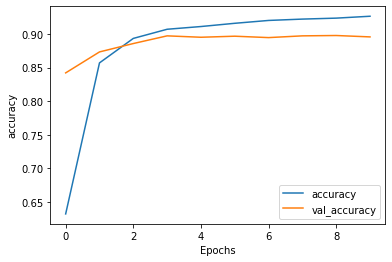

In [ ]:
plot_graphs(history_1, "accuracy")

## Inferencing on unseen samples

In [ ]:
lstm_recommender = tf.keras.models.load_model('./drive/MyDrive/Colab_Notebooks/lstm_recommender_model')

sample_text = [('Very positive experience with Indigo. Easy baggage-drop at Lucknow airport, new aircraft,' 
                'well trained crew. Very good airline, warmly recommended.'),
               ('Indigo charges extra for its seat selection. And now I dont understand why the flight attendant asked '
               'me to change my seat which is lower than what i paid. I left with no choice cause its for an child ' 
                'with 2.5yrs. Its crazy Indigo has to fine tune its reservation system. The family who booked'
                'the seats got the seats in 3 different places.'),
               ('Recently as an international travel booked return flight, continue to experience problems of scheduling '
               'and rescheduling by the airline, with no head or tail. Difficult to contact either online or web chat '
               'or on the phone to speak to customer service from abroad from abroad. The whole service is below par.'),
               ('No doubt Indigo is best LCC in India, smooth check in, on time sequential boarding and departure. Okay seats, '
               'clean hygiene cabin, courteous cabin crew. Another good experience and reason to fly again with them next time.'),
               ('I used the Indigo flight from Jaipur to Bengaluru. It was ok.')]

for count, st in enumerate(sample_text):  
  predictions = lstm_recommender.predict(np.array([st]), verbose=0)
  p = np.squeeze(predictions)
  recommended = 'Yes' if p > 0 else 'No'
  print("In Statement {} Recommended Flight is = {}".format(count+1, recommended))
  

In Statement 1 Recommended Flight is = Yes
In Statement 2 Recommended Flight is = No
In Statement 3 Recommended Flight is = No
In Statement 4 Recommended Flight is = Yes
In Statement 5 Recommended Flight is = Yes
